In [1]:
from diffusers import DiffusionPipeline
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

# load both base & refiner
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.enable_model_cpu_offload()

refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.enable_model_cpu_offload()

# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 40
high_noise_frac = 0.8

prompt = "A majestic lion jumping from a big stone at night"

# run both experts
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images


gc.collect()
torch.cuda.empty_cache()

image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacty of 7.79 GiB of which 381.38 MiB is free. Including non-PyTorch memory, this process has 6.87 GiB memory in use. Of the allocated memory 6.33 GiB is allocated by PyTorch, and 343.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

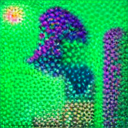

In [2]:
image